# <font style="color:blue">Classification Evaluation Metrics</font>

In this notebook, we will see in details how to implement the different metrics in code. You should note that most of thes metrics are available in popular ML packages like SK Learn etc. The purpose of this notebook is to strengthen your understanding. These metrics play a very important role while making business decisions and every data scientist of ML practitioner should know their significance as well as their inner working.

# <font style="color:blue">1. Create the Model</font>

For the sake of simplicity, we will illustrate the performance metrics for the task of point classification to two classes: `[0, 1]`.

To begin with, let's import all of the required packages.

In [16]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [17]:
plt.rcParams["figure.figsize"] = (8, 8)

# <font style="color:blue">2. Generate Dataset</font>

The Sickit-Learn library provides a range of supervised and unsupervised machine learning algorithms. [A blog on Introduction to Scikit-Learn](https://towardsdatascience.com/an-introduction-to-scikit-learn-the-gold-standard-of-python-machine-learning-e2b9238a98ab). 

For our purposes, we need to create a dataset. We use [make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function from scikit-learn library.
It generates a random n-class classification problem with normally distributed clusters of points. We also add uniformly distributed points as noise to our data.

To get the details about the functon `sklearn.datasets.make_classification` read [here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html).

Inputs (X) shape: (100, 2)
Lables (y) shape: (100,)


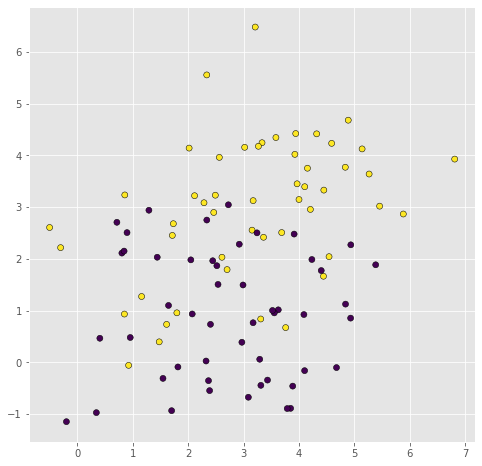

In [18]:
# for reproducible results
seed = 42  
rng = np.random.RandomState(seed)
torch.manual_seed(seed)


# generate two class classification problem
X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=seed, n_clusters_per_class=1
)

# add unifom random noise
X += 4 * rng.uniform(size=X.shape)

print('Inputs (X) shape: {}'.format(X.shape))
print('Lables (y) shape: {}'.format(y.shape))

plt.scatter(X[:,0],X[:,1],c=y,edgecolor='k')

# <font style="color:blue">3. Train the Model</font>

Here we will train a [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression) classifier. Logistic regression is equivalent to a one-layer neural network with sigmoid activation. We have already implemented this using the basic functionality of PyTorch. Let's implement it again using PyTorch NN-module. 

We are using sigmoid activation, so the model prediction will be the prediction probability of class `1`.

Its good practice to create different classes for different functionality. For example, in our case, we have to train a  model. It has two parts, 1. Model, and 2. Training. Suppose we want to train different models to find the best model for the dataset (this is common practice in Machine Learning). So it's a good idea to have a `trainer` class which takes `model` and `data` and trains it.

Let's start with this practice. Here, we will create two classes, `LogisticRegression` (model) and `Trainer`.

## <font style="color:rgb(8,133,37)">3.1. Create the Model Class</font>

There is `LogisticRegression` class that has the following methods: 

**`__init__`:**  It takes `n_featurs` (number of input data features) and initiates `nn-linear` function.

**`forward`:** It takes `x` (data input) and does forward pass of the network.

In [19]:
class LogisticRegression(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        
        # define linear layer (WX + B)
        self.linear = nn.Linear(n_features, 1, bias=True)

    def forward(self, x):
        # calculate WX + B
        x = self.linear(x)
        
        # sigmoid activation (prediction probability of class 1)
        predictions = torch.sigmoid(x)
        return predictions

## <font style="color:rgb(8,133,37)">3.2. Create the Trainer Class</font>

Since pytorch doesn't provide unified methods for training, we can create simple `Trainer` class to fit our model and make predictions.

**`Trainer` class has the following methods:**

**`__init__`:** 

It takes three arguments.
        
- `model`: which has to be trained. Although We will be passing the above-defined Linear Regression Model here, It can take any PyTorch model.
 
- `criterion`: It  takes any NN-module loss function.
        
- `optimizer`: It takes the optimizer algorithm method.
        
- `epoch_num`: Number of epochs for training.

**`fit`:** It takes two arguments, input and target.

This method does the following:
1. Do forward pass of the `model`  with the `input`.

1. Find loss using forward pass and `target`.

1. Find `gradient` using `backprop`.

1. Update parameters using `step`

**`predict`:** It takes `input` as an argument. It just does forward pass and return prediction.


In [20]:
class Trainer:
    def __init__(self, model, criterion, optimizer, epoch_num):
        self.model = model
        
        # loss function
        self.criterion = criterion
        
        # Optimizer
        self.optimizer = optimizer
        
        # num of epochs
        self.epoch_num = epoch_num

    def fit(self, inputs, targets):
        """
        Updating model trainable parameters in loop for given number of epochs
        """
        
        # set model in train state. 
        # Why it (and model.eval()) is important, 
        # we will see when we will be training a deep neural network.
        self.model.train()
        
        # run train loop for given epochs
        for _ in range(self.epoch_num):
            
            # reset previously calculated gradient to zero
            self.optimizer.zero_grad()
            
            # predict probability of class '1'
            preds = self.model(inputs)
            
            # get loss
            loss = self.criterion(preds, targets)
            
            # calculate gradients
            loss.backward()
            
            # update parameters with gradient
            self.optimizer.step()

    def predict(self, inputs):
        
        # set model in train state. 
        self.model.eval()
        # temporarily set requires_grad flag to false
        with torch.no_grad():
            # probability of class one prediction
            preds = self.model(inputs)
        return preds

## <font style="color:rgb(8,133,37)">3.3. Training and Prediction</font>

1. Divide the data into `train` and `test` data (`25` %).

1. Create a model object using `LogisticRegression` model class.

1. Define `criterion` as binary cross-entropy loss.

1. Define `optimizer` as `SGD` optimizer.

1. Create the trainer object.

1. Train the model using `fit` method defined in `Trainer` class.

1. Finally, get predictions for test data.


In [21]:
# Divide data into train (0.75)vand test (0.25) set. 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

# train data from numpy to torch
x_train, y_train = torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float()

# create model object
log_regression = LogisticRegression(n_features=2)

# define loss. Here binary cross-entropy loss
criterion = nn.BCELoss()

# define optimizer. Here Stochastic Gradient Descent  
optimizer = torch.optim.SGD(log_regression.parameters(), lr=0.01)

# create trainer object
trainer = Trainer(log_regression, criterion, optimizer, 200)

# train the model
trainer.fit(x_train, y_train)

# test data from numpy to torch
x_test, y_test = torch.from_numpy(x_test).float(), torch.from_numpy(y_test).float()

# probability of class one prediction
y_predicted = trainer.predict(x_test)

# <font style="color:blue">4. Confusion Matrix</font>

<img src="https://www.learnopencv.com/wp-content/uploads/2020/01/c3_w3_confusion_matrix.png" width=600>

Let's assume class `1` is **`positive`** class, and class `0` is **`negative`** class.

To get the confusion matrix and other methods derived from confusion matrix, we have implemented the `ConfusionMatrix` class. It has the following methods:

**`__init__`:**  `self.conf` (confusion matrix variable) is iniated with `2x2` `ndarray`.

**`reset`:** Resetting `self.conf` to zero.

**`add`:** It takes `pred` (prediction), and `target` (target label) to update `self.conf` .  Using `numpy.histogramdd` to get multidimensional histogram. More details about the function find [here](https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogramdd.html). 

Let's see what it is happing in the implementation.

`np.histogramdd(replace_indices, bins=(2, 2), range=[(0, 2), (0, 2)])`


let's `replace_indices` is `7 x 2` `ndarray`, where Column `0` corresponds to `target` and column `1` corresponds to `prediction`.

```
replace_indices = [ [0, 1],
                    [0, 0],
                    [1, 1],
                    [1, 1],
                    [1, 0],
                    [0, 1],
                    [0, 0] ]
```

`bins=(2, 2)` means it will return `2 X 2` `ndarray`.

`range=[(0, 2), (0, 2)])` means it will have the following bins:
```
[0, 0], [0, 1], [1, 0] and [1, 1]
```

So the following `ndarray` will return:
```
[[count_of([0, 0]), count_of([0, 1])],
 [count_of([1, 0]), count_of([1, 1])]] 
i.e.
[[2, 2],
 [1, 2]]
```

Hence, `0` is the negative class, and `1` is the positive class:
```
count_of([1, 1]) = TP,
count_of([0, 1]) = FP,
count_of([0, 0]) = TN, and
count_of([1, 0]) = FN
```

**`TP`:** Returns `true positive`

**`FP`:** Returns `false positive`

**`TN`:** Returns `true negative`

**`FN`:** Returns `false negative`

**`confusion_matrix`:** Returns confusion matrix:
```
[[TP, FP],
 [FN, TN]]
```



In [22]:
class ConfusionMatrix:
    def __init__(self):
        # init confusion matrix
        self.conf = np.ndarray((2, 2), np.int32)

    def reset(self):
        # reset to zero
        self.conf.fill(0)

    def add(self, pred, target):
        """
        This will take predicted probability and True label and compute confusion matrix
        """
        replace_indices = np.vstack((target.flatten(), pred.flatten())).T

        conf, _ = np.histogramdd(replace_indices, bins=(2, 2), range=[(0, 2), (0, 2)])

        self.conf += conf.astype(np.int32)

    def TP(self):
        return self.conf[1,1]
    
    def FP(self):
        return self.conf[0, 1]
    
    def TN(self):
        return self.conf[0, 0]
    
    def FN(self):
        return self.conf[1, 0]
    
    def confusion_matrix(self):
        """
        get confusion matrix as defined in figure
        """
        cm = np.array([[self.TP(), self.FP()],
                      [self.FN(), self.TN()]])
        return cm

Let's compute confusion matrix for threshold probability `0.5` and `0.7`.

Get the confusion matrix by the following steps:
1. Init the `ConfusionMatrix` class.
1. Get `prediction` by using`y_predicted` and `threshold probability` .
1. Reset the confusion matrix.
1. Compute confusion matrix using `add`.
1. Call `confusion_matrix()`

In [23]:
# threshold probability 0.5

cm = ConfusionMatrix()

thres_prob = 0.5
predictions = y_predicted > thres_prob

# reset cunfusion matrix
cm.reset()

# compute confusion matrix
cm.add(predictions, y_test)


print('Confusion Matrix for threshold probability 0.5:\n{}'.format(cm.confusion_matrix()))


thres_prob = 0.6
predictions = y_predicted > thres_prob

# reset confusion matrix
cm.reset()

# compute confusion matrix
cm.add(predictions, y_test)


print('Confusion Matrix for threshold probability 0.6:\n{}'.format(cm.confusion_matrix()))


Confusion Matrix for threshold probability 0.5:
[[8 6]
 [3 8]]
Confusion Matrix for threshold probability 0.6:
[[ 7  4]
 [ 4 10]]


# <font style="color:blue">5. Accuracy</font>

<img src="https://www.learnopencv.com/wp-content/uploads/2020/01/c3_w3_accuracy.png" width=600>

$$
accuracy = \frac{TP + TN}{TF + FP + FN + TN }
$$

In [24]:
def accuracy(thres_prob, y_predicted, y_true):
    predictions = y_predicted > thres_prob

    # reset cunfusion matrix
    cm.reset()
    # compute confusion matrix
    cm.add(predictions, y_true)
    
    # accuracy 
    acc = (cm.TP() + cm.TN())/(cm.TP() + cm.FP() + cm.FN() + cm.TN())
    
    return acc


In [25]:
acc = accuracy(0.5, y_predicted, y_test)

print('Accuracy at threhold 0.5: {}'.format(acc))

Accuracy at threhold 0.5: 0.64


# <font style="color:blue">6. Precision</font>

<img src="https://www.learnopencv.com/wp-content/uploads/2020/01/c3_w3_precision.png" width=600>

$$
precision = \frac{TP}{TP + FP}
$$

In [26]:
def precision(thres_prob, y_predicted, y_true):
    predictions = y_predicted > thres_prob

    # reset cunfusion matrix
    cm.reset()
    # compute confusion matrix
    cm.add(predictions, y_true)
    
    # precision
    pre = cm.TP()/(cm.TP() + cm.FP())
    
    return pre

In [27]:
pre = precision(0.5, y_predicted, y_test)

print('Precision at threhold 0.5: {0:.3}'.format(pre))

Precision at threhold 0.5: 0.571


# <font style="color:blue">7. Recall / Sensitivity</font>

<img src='https://www.learnopencv.com/wp-content/uploads/2020/01/c3_w3_recall.png' width=600>

$$
recall = \frac{TP}{TP + FN}
$$

In [28]:
def recall(thres_prob, y_predicted, y_true):
    predictions = y_predicted > thres_prob

    # reset cunfusion matrix
    cm.reset()
    # compute confusion matrix
    cm.add(predictions, y_true)
    
    # recall
    rec = cm.TP()/(cm.TP() + cm.FN())
    
    return rec
    

In [29]:
rec = recall(0.5, y_predicted, y_test)

print('Recall at threhold 0.5: {0:.3}'.format(rec))

Recall at threhold 0.5: 0.727


# <font style="color:blue">8. F-1 Score</font>

$$
F_1 score = \frac{2 TP}{2TP + FP + FN}
$$


In [30]:
def f1_score(thres_prob, y_predicted, y_true):
    predictions = y_predicted > thres_prob

    # reset cunfusion matrix
    cm.reset()
    # compute confusion matrix
    cm.add(predictions, y_true)
    
    # f1 score
    score = (2*cm.TP())/(2*cm.TP() + cm.FP() + cm.FN())
    
    return score
    

In [31]:
f1_score = f1_score(0.5, y_predicted, y_test)

print('F1 score at threhold 0.5: {}'.format(f1_score))

F1 score at threhold 0.5: 0.64


# <font style="color:blue">9. ROC Curve</font>

<img src="https://www.learnopencv.com/wp-content/uploads/2020/01/c3_w3_roc.png" width=700>


\begin{align}
TPR (recall) &= \frac{TP}{TP + FN} \\
FPR &= \frac{FP}{FP + TN} \\
\end{align}

## <font style="color:rgb(8,133,37)">9.1. ROC Curve using Confusion Matrix</font>

For `threshold_probability` in `[0, 1]`:
1. By using `ConfusionMatrix` class get `TP` (true positive), `FP` (false positive), `FN` (false negative), and `TN` (true negative).

2. Calculate `TPR` (true positive rate) and `FPR` (false positive rate).

Plot `TPR-vs-FPR`.


In [32]:
thresholds = np.linspace(0.001, 0.999, 1000)

tp_rates = []
fp_rates = []
cm = ConfusionMatrix()

for threshold in thresholds:

    # get prediction
    predictions = y_predicted > threshold
    
    # rest confusion matrix
    cm.reset()
    
    # calculate confusion matrix
    cm.add(predictions, y_test)
    
    # get TP, FP, FN, and TN to calculate TPR and FPR
    TN = cm.TN()
    FP = cm.FP()
    FN = cm.FN()
    TP = cm.TP()

    # Sensitivity, recall, or true positive rate
    TPR = TP / (TP + FN)
    tp_rates.append(TPR)

    # False positive rate
    FPR = FP / (FP + TN)
    fp_rates.append(FPR)

**Let's plot `true positive rate` vs `false positive rate`.**

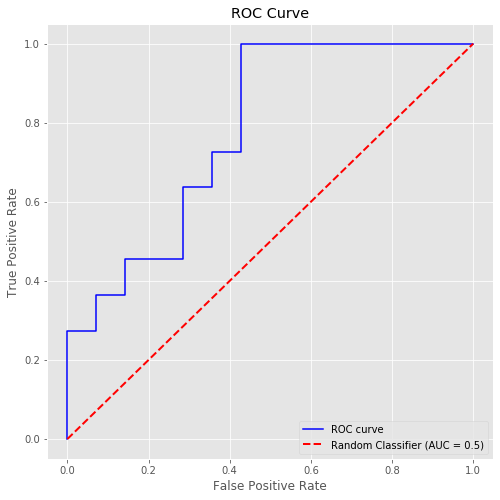

In [33]:
plt.plot(fp_rates, tp_rates, label='ROC curve', color='b')
plt.plot([0, 1], [0, 1], label='Random Classifier (AUC = 0.5)', linestyle='--', lw=2, color='r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curve')
plt.show()

## <font style="color:rgb(8,133,37)">9.2. ROC Curve using Definition & AUC</font>

In order to plot ROC Curve and calculate ROC AUC Score, let's create a class `ROCCurve`. In this approach, we build the ROC Curve using [False Positive](https://en.wikipedia.org/wiki/False_positive_rate) and [True Positive](https://en.wikipedia.org/wiki/Sensitivity_and_specificity#Sensitivity) Rates.

By increasing the threshold between two classes and calculating a number of `true positives`, `true negatives`, `false positives` and `false negatives` for each of them, we can get a set of corresponding `true positive rate` and `false positive rates`.

We also write an `ROCCurve` class that has methods to plot ROC curve and calculate AUC. Let's have a look at all methods:

**`__init__`:** It takes `y_test` and `y_pred_score` as arguments and initiate attributes `y_test` and `y_pred_score` respectively. 

**`_get_fpr_tpr`:** returns `FPR` and `TPR` for a range of thresholds.

**`_get_tp_fp_tn_fn`:** returns `TP`, `FP`, `TN`, and `FN` for a range of threhold.

**`plot_roc`:** get `TPR` and `FPR` from `_get_fpr_tpr` and plot `TPR`-vs-`FPR` (ROC Curve).

**`get_auc_score`:** get `TPR` and `FPR` from `_get_fpr_tpr` and calculate `AUC`.

In [40]:
class ROCCurve:
    def __init__(self, y_test, y_pred_score):
        # Init attributs 
        self.y_test = y_test
        self.y_pred_score = y_pred_score

    def _get_fpr_tpr(self):
        # thresholds
        thresholds = torch.linspace(0.001, 0.999, 1000).unsqueeze(1)
        
        # get prediction for all thresholds
        self.y_pred = self.y_pred_score.T > thresholds
        
        # get TP, FP, TN, and FN for all thresholds
        tp, fp, tn, fn = self._get_tp_fp_tn_fn()
        
        # calculate true positive rate for all thresholds
        tpr = tp.float() / (tp + fn)
        
        # calculate false positive rate for all thresholds
        fpr = fp.float() / (fp + tn)
        
        return fpr.flip((0, )), tpr.flip((0, ))
        

    def _get_tp_fp_tn_fn(self):
        
        # change datatype to bool
        self.y_pred = self.y_pred.bool()
        self.y_test = self.y_test.bool()
        
        # calculate TP
        tp = (self.y_pred & self.y_test).sum(dim=1)
        
        # calculate FP
        fp = (self.y_pred & ~self.y_test).sum(dim=1)
        
        # calculate TN
        tn = (~self.y_pred & ~self.y_test).sum(dim=1)
        
        # calculate FN
        fn = (~self.y_pred & self.y_test).sum(dim=1)
        
        return tp, fp, tn, fn

    def plot_roc(self):
        
        # get TPR and FPR and plot TPR-vs-FPR
        plt.plot(*self._get_fpr_tpr(), label='ROC curve', color='g')
        plt.plot([0, 1], [0, 1], label='Random Classifier (AUC = 0.5)', linestyle='--', lw=2, color='r')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.title('ROC Curve')
        plt.show()

    def get_auc_score(self):
        # Get TPR and FPR
        fpr, tpr = self._get_fpr_tpr()
        
        # get area under the curve of TPR-vs-FPR plot
        return np.trapz(tpr, fpr), fpr, tpr

**Now we can use an object of our class to plot the ROC curve**

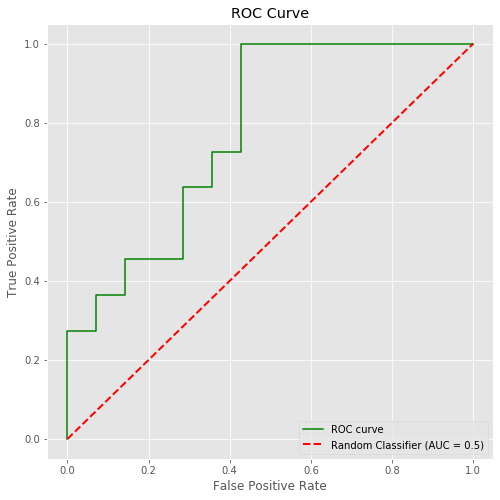

In [41]:
roc_auc = ROCCurve(y_test, y_predicted)
roc_auc.plot_roc()

**Also we implemented the function to calculate the area under the ROC curve.**

In [42]:
roc_auc_score, fpr, tpr = roc_auc.get_auc_score()
print('ROC AUC Score: {0:.3}'.format(roc_auc_score))

ROC AUC Score: 0.779
